In [ ]:
#pip install transformers

In [3]:
from transformers import BertTokenizer

In [4]:
import tensorflow as tf
import numpy as np
import os

In [5]:
file = tf.keras.utils.get_file(
    'shakespeare.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
)

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
type(file)

str

In [7]:
file

'/root/.keras/datasets/shakespeare.txt'

In [8]:
text = open(file,'rb').read().decode(encoding = 'utf-8')

In [9]:
type(text)

str

In [10]:
len(text)

1115394

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# TOKENIZATION

In [12]:
tokens = tokenizer.tokenize(text)

In [13]:
input_ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens[:10])
print(input_ids[:10])

['first', 'citizen', ':', 'before', 'we', 'proceed', 'any', 'further', ',', 'hear']
[2034, 6926, 1024, 2077, 2057, 10838, 2151, 2582, 1010, 2963]


# ip, op sequence gen

In [14]:
max_seq_length = 5  # number of context tokens.hyperparam can TWEEK

sequences = []
labels = []

for i in range(len(input_ids) - max_seq_length):
    seq = input_ids[i: i + max_seq_length]
    label = input_ids[i + max_seq_length]
    sequences.append(seq)
    labels.append(label)

X = tf.constant(sequences)
y = tf.constant(labels)

# BERT + BiLSTM model
Takes in tokenized input (input IDs + attention masks)

Passes it through a frozen BERT model (so its weights don’t change)

Gets the output embeddings (contextual word representations)

Feeds them into a Bidirectional LSTM to learn sequential patterns

Outputs a probability distribution (via Dense(..., activation="softmax")) — like predicting the next word or a class label

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Lambda
from tensorflow.keras.models import Model
from transformers import TFBertModel

# Constants
vocab_size = 30522  # for BERT-base
hidden_size = 768   # BERT hidden size

# Load pretrained BERT
bert = TFBertModel.from_pretrained("bert-base-uncased")
bert.trainable = False

# ✅ Variable-length input (None instead of fixed length)
input_ids = Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(None,), dtype=tf.int32, name="attention_mask")

# Lambda wrapper for BERT
def get_bert_output(inputs):
    input_ids, attention_mask = inputs
    output = bert(input_ids=input_ids, attention_mask=attention_mask)
    return output.last_hidden_state  # shape: (batch, seq_len, 768)

bert_embedding = Lambda(
    get_bert_output,
    output_shape=lambda s: (s[0][0], s[0][1], hidden_size)  # dynamic output shape
)([input_ids, attention_mask])

# RNN and Output
x = Bidirectional(LSTM(150))(bert_embedding)
output = Dense(vocab_size, activation="softmax")(x)

# Final model
model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, None, 768)      │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 300)            │      1,102,800 │ lambda_1[0][0]         │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 30522)          │      9,187,122 │ bidirectional_1[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,289,922 (39.25 MB)

 Trainable params: 10,289,922 (39.25 MB)

 Non-trainable params: 0 (0.00 B)

# Compiling and training

In [27]:
# 1. Create attention masks (all 1s since no padding)
attention_masks = tf.ones_like(X)  # Shape: (num_samples, max_seq_length)

# 2. Compile the model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# ⚡️ Optional: Use a subset for faster experimentation
# Remove this if you're ready for full training
'''
X_sample = X[:1000]
attention_masks_sample = attention_masks[:1000]
y_sample = y[:1000]
'''
# SAEV checkpoints
# Create the directory for saving checkpoints (if it doesn't exist)
checkpoint_dir = './bert_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the checkpoint path
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

# Create the callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_freq='epoch'
)

# 3. Train the model
history = model.fit(
    [X, attention_masks],
    y,
    epochs=20,
    batch_size=128,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 176s 71ms/step - accuracy: 0.0977 - loss: 6.2982
Epoch 2/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 199s 70ms/step - accuracy: 0.1570 - loss: 5.1719
Epoch 3/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 158s 70ms/step - accuracy: 0.1805 - loss: 4.8293
Epoch 4/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 204s 71ms/step - accuracy: 0.1953 - loss: 4.5322
Epoch 5/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 201s 71ms/step - accuracy: 0.2089 - loss: 4.2627
Epoch 6/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 202s 70ms/step - accuracy: 0.2331 - loss: 4.0024
Epoch 7/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 159s 70ms/step - accuracy: 0.2582 - loss: 3.7974
Epoch 8/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 202s 70ms/step - accuracy: 0.2793 - loss: 3.6330
Epoch 9/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 203s 71ms/step - accuracy: 0.2960 - loss: 3.4942
Epoch 10/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 202s 71ms/step - accuracy: 0.3099 - loss: 3.3719
Epoch 11/20
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 158s 70ms/step - accuracy: 0.3239 - loss: 3.26

# Training Curve

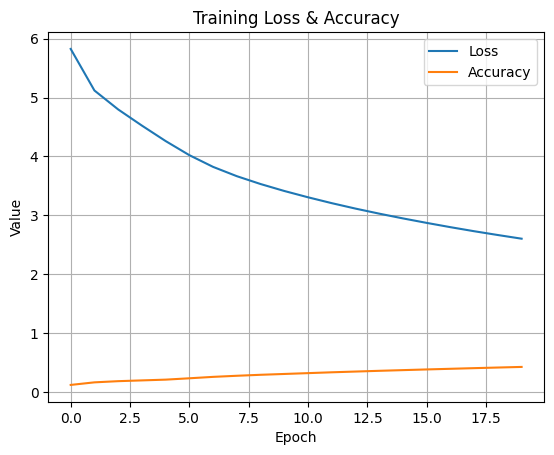

In [28]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss & Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# Text Generation Function

In [31]:
def generate_text(prompt, model, tokenizer, max_length=50):
    input_ids = tokenizer.encode(prompt, return_tensors='tf')  # Shape: (1, seq_len)
    attention_mask = tf.ones_like(input_ids)
    generated = input_ids

    for _ in range(max_length):
        predictions = model([generated, attention_mask])  # Shape: (1, vocab_size)
        next_token_logits = predictions  # ✔ no need for [:, -1, :]
        next_token_id = tf.random.categorical(next_token_logits, num_samples=1)[0, 0]

        generated = tf.concat([generated, [[next_token_id]]], axis=1)
        attention_mask = tf.ones_like(generated)

    output_text = tokenizer.decode(generated[0], skip_special_tokens=True)
    return output_text

In [35]:
generate_text("WASSUP", model, tokenizer)

'wassup» luminoushesionuddin coined geographic manchester [unused986] commanded want ridingroidsу kraft sicilian shale verdict orientationnia under paradigmhitonia autonomous railroad [unused195] utilizes middleton lok清 ivanov oriconckedsomerasia帝 classifydim africans braves vicinity survive ァ 2001 prints attributedity resolvedver end'

#  Save Entire Model

In [36]:
model.save("bert_word_generator.keras")

# Downloading shit

In [42]:
!zip -r bert_checkpoints.zip /content/bert_checkpoints

  adding: content/bert_checkpoints/ (stored 0%)
  adding: content/bert_checkpoints/ckpt_2.weights.h5 (deflated 11%)
  adding: content/bert_checkpoints/ckpt_17.weights.h5 (deflated 13%)
  adding: content/bert_checkpoints/ckpt_9.weights.h5 (deflated 13%)
  adding: content/bert_checkpoints/ckpt_5.weights.h5 (deflated 11%)
  adding: content/bert_checkpoints/ckpt_3.weights.h5 (deflated 11%)
  adding: content/bert_checkpoints/ckpt_12.weights.h5 (deflated 13%)
  adding: content/bert_checkpoints/ckpt_11.weights.h5 (deflated 13%)
  adding: content/bert_checkpoints/ckpt_6.weights.h5 (deflated 12%)
  adding: content/bert_checkpoints/ckpt_4.weights.h5 (deflated 11%)
  adding: content/bert_checkpoints/ckpt_10.weights.h5 (deflated 13%)
  adding: content/bert_checkpoints/ckpt_16.weights.h5 (deflated 13%)
  adding: content/bert_checkpoints/ckpt_19.weights.h5 (deflated 13%)
  adding: content/bert_checkpoints/ckpt_13.weights.h5 (deflated 13%)
  adding: content/bert_checkpoints/ckpt_20.weights.h5 (deflat

In [45]:
!du -sh /content/bert_checkpoints

2.5G	/content/bert_checkpoints


In [47]:
import os

checkpoints = [f for f in os.listdir('/content/bert_checkpoints') if f.endswith('.h5')]

# Filter only those with numeric epoch values
numeric_checkpoints = [
    f for f in checkpoints if f.split('_')[1].split('.')[0].isdigit()
]

# Sort by epoch number
latest_checkpoint = sorted(numeric_checkpoints, key=lambda x: int(x.split('_')[1].split('.')[0]))[-1]

print("Latest checkpoint:", latest_checkpoint)


Latest checkpoint: ckpt_20.weights.h5


In [48]:
from google.colab import files
files.download('/content/bert_checkpoints/ckpt_20.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
file_path = '/content/bert_word_generator.keras'
file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
print(f"File size: {file_size_mb:.2f} MB")

File size: 117.80 MB


In [51]:
from google.colab import files
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>